# Меня ждут миллионы

Обучите простую модель предсказания цены акций. Используйте один из рассмотренных на лекции "Временные последовательности" алгоритмов предсказания рядов. Можно использовать и более сложные алгоритмы предсказания рядов


1. Найдите данные о цене любого биржевого актива

    Данные должны содержать значение цены актива как минимум за каждый день и длительностю как минимум за год. 

    Найти данные можно на kaggle или использовать FAANG датасет из 1 лабораторной


2. Предобработайте данные

    Временной ряд сложно предсказывать по дням. Сделайте ряд по неделям или месяцам
   
    Удалите из ряда тренд, если он есть. Используйте другие рассмотренные на лекции приёмы


3. Обучите модель
    
    Обучите модель на 80% временного ряда
    
    Предскажите оставшиеся 20% (как минимум 3 точки) ряда с помощью модели 
    
    Отобразите на графике предсказание модели и истинные данные


4. Посчитайте метрику

    Метрика должна отражать разницу между предсказанными и истинными данными. Можно выбрать меру MAPE, можно предложить свою

In [1]:
# Импорт необходимых библиотек
import copy
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from dateutil.relativedelta import relativedelta

# Source: https://www.statsmodels.org/stable/install.html
import statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Source: https://scikit-learn.org/stable/install.html
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
amazon = pd.read_csv('./Amazon.csv')
amazon.head(15)

,Date,Open,High,Low,Close,Adj Close,Volume
0,1997-05-15,2.437500,2.500000,1.927083,1.958333,1.958333,72156000
1,1997-05-16,1.968750,1.979167,1.708333,1.729167,1.729167,14700000
2,1997-05-19,1.760417,1.770833,1.625000,1.708333,1.708333,6106800
3,1997-05-20,1.729167,1.750000,1.635417,1.635417,1.635417,5467200
4,1997-05-21,1.635417,1.645833,1.375000,1.427083,1.427083,18853200
5,1997-05-22,1.437500,1.447917,1.312500,1.395833,1.395833,11776800
6,1997-05-23,1.406250,1.520833,1.333333,1.500000,1.500000,15937200
7,1997-05-27,1.510417,1.645833,1.458333,1.583333,1.583333,8697600
8,1997-05-28,1.625000,1.635417,1.531250,1.531250,1.531250,4574400
9,1997-05-29,1.541667,1.541667,1.479167,1.505208,1.505208,3472800


In [3]:
amazon.shape

(6155, 7)

In [4]:
amazon.describe()

,Open,High,Low,Close,Adj Close,Volume
count,6155.000000,6155.000000,6155.000000,6155.000000,6155.000000,6.155000e+03
mean,520.556302,526.216132,514.277282,520.429832,520.429832,7.329010e+06
std,857.161696,865.821041,847.270905,856.668492,856.668492,7.149521e+06
min,1.406250,1.447917,1.312500,1.395833,1.395833,4.872000e+05
25%,38.750000,39.514999,38.104999,38.821251,38.821251,3.579350e+06
50%,92.669998,94.190002,90.750000,92.639999,92.639999,5.470000e+06
75%,528.949982,535.304993,521.950012,529.450012,529.450012,8.294950e+06
max,3744.000000,3773.080078,3696.790039,3731.409912,3731.409912,1.043292e+08


In [5]:
amazon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6155 entries, 0 to 6154
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       6155 non-null   object 
 1   Open       6155 non-null   float64
 2   High       6155 non-null   float64
 3   Low        6155 non-null   float64
 4   Close      6155 non-null   float64
 5   Adj Close  6155 non-null   float64
 6   Volume     6155 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 336.7+ KB


In [6]:
amazon['Date'] = pd.to_datetime(amazon['Date'], format='%Y-%m-%d')
amazon.sort_index(inplace=True)
amazon.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1997-05-15,2.437500,2.500000,1.927083,1.958333,1.958333,72156000
1,1997-05-16,1.968750,1.979167,1.708333,1.729167,1.729167,14700000
2,1997-05-19,1.760417,1.770833,1.625000,1.708333,1.708333,6106800
3,1997-05-20,1.729167,1.750000,1.635417,1.635417,1.635417,5467200
4,1997-05-21,1.635417,1.645833,1.375000,1.427083,1.427083,18853200


In [7]:
amazon.drop(['Open', 'Low', 'Close', 'Adj Close', 'Volume'], axis=1, inplace = True)
amazon.head()

,Date,High
0,1997-05-15,2.500000
1,1997-05-16,1.979167
2,1997-05-19,1.770833
3,1997-05-20,1.750000
4,1997-05-21,1.645833


In [8]:
import datetime
last_month = -1

df = pd.DataFrame(columns=['Date', 'High'])
for row in amazon.itertuples():
    if (last_month != row.Date.month):
        last_month = row.Date.month
        df = df.append({'Date': datetime.date(row.Date.year, row.Date.month, 1), 'High': row.High}, ignore_index=True)
        
amazon = df
amazon.shape

(294, 2)

In [9]:
amazon = amazon.set_index(['Date'])
amazon.head()

,High
Date,
1997-05-01,2.500000
1997-06-01,1.531250
1997-07-01,1.541667
1997-08-01,2.416667
1997-09-01,2.375000


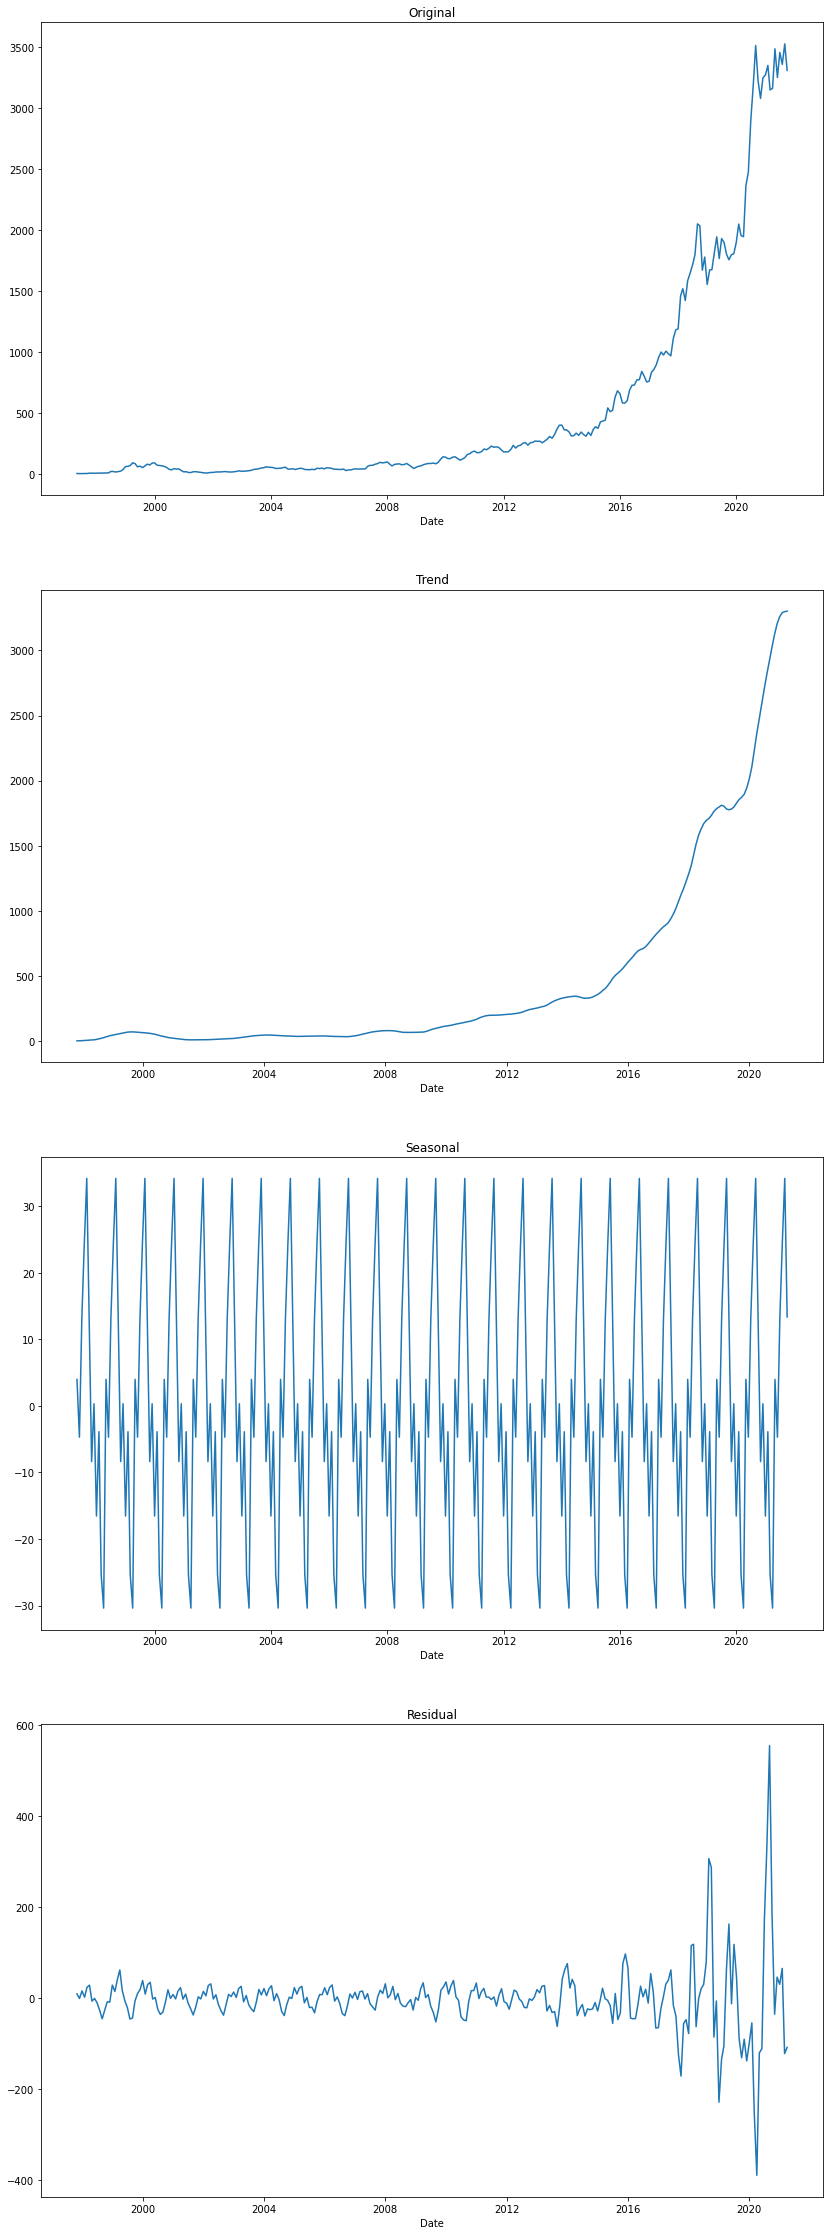

In [10]:
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(14, 40))
decompose = seasonal_decompose(amazon[['High']], period=12)

ax[0].set_title('Original')
ax[1].set_title('Trend')
ax[2].set_title('Seasonal')
ax[3].set_title('Residual')

decompose.observed.plot(ax=ax[0])
decompose.trend.plot(ax=ax[1])
decompose.seasonal.plot(ax=ax[2])
decompose.resid.plot(ax=ax[3]);

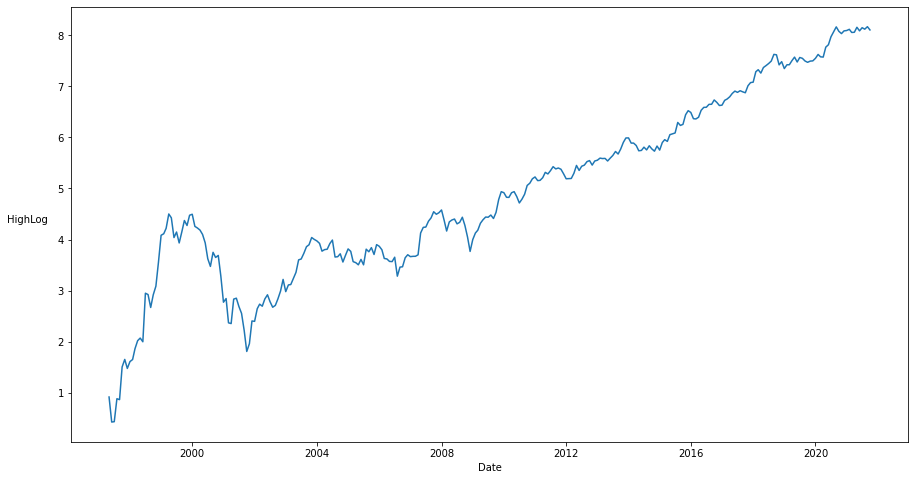

In [11]:
amazon['HighLog'] = np.log(amazon['High'])

plt.figure(figsize=(15, 8))
plt.ylabel('HighLog', rotation=0, labelpad=30)
amazon['HighLog'].plot();

Полученный уровень значимости (p-value): 0.0039. 0.0039 < 0.05. Нулевая гипотеза отвергается в пользу альтернативной!


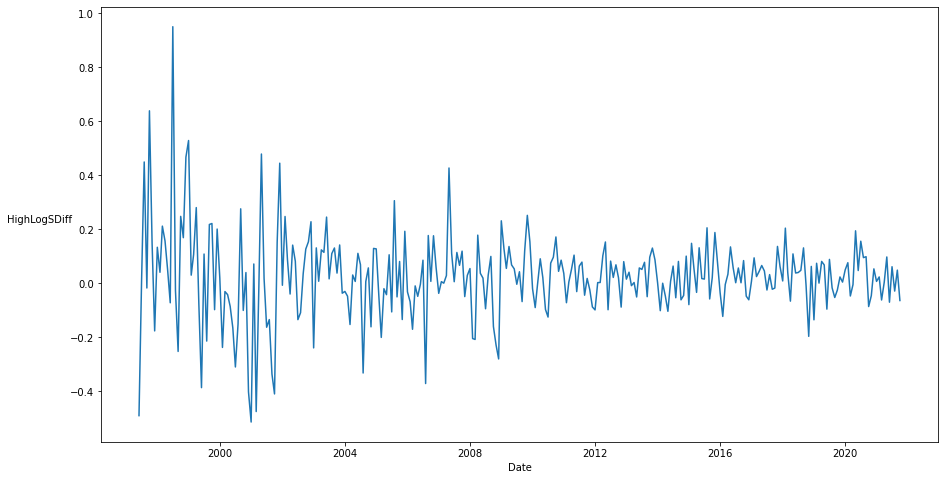

In [12]:
amazon['HighLogSDiff'] = amazon['HighLog'] - amazon['HighLog'].shift(1)
p_value = adfuller(amazon["HighLogSDiff"][1:])[1]

print(
    f'Полученный уровень значимости (p-value): {round(p_value, 4)}.',
    f'{round(p_value, 4)} < 0.05. Нулевая гипотеза отвергается в пользу альтернативной!'
)

plt.figure(figsize=(15, 8))
plt.ylabel('HighLogSDiff', rotation=0, labelpad=30)
amazon['HighLogSDiff'].plot();

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


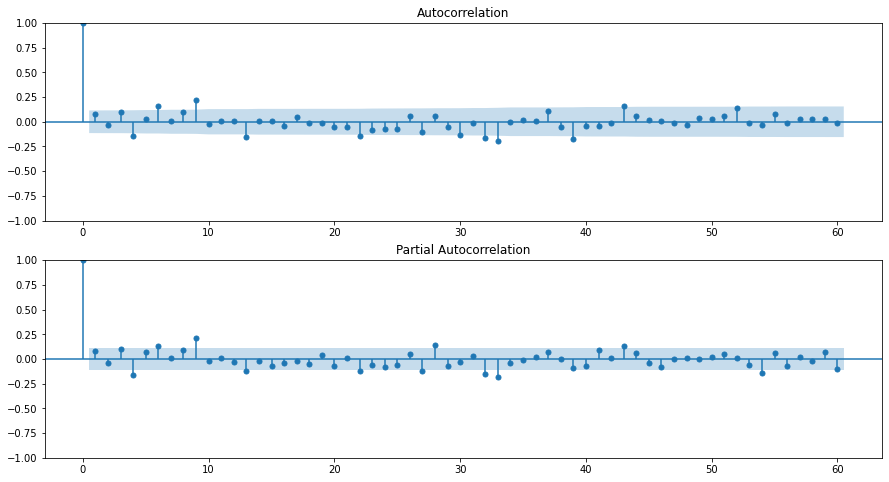

In [13]:
plt.figure(figsize=(15,8))

ax = plt.subplot(211)
statsmodels.graphics.tsaplots.plot_acf(amazon['HighLogSDiff'][1:], lags=60, ax=ax)

ax = plt.subplot(212)
statsmodels.graphics.tsaplots.plot_pacf(amazon['HighLogSDiff'][1:], lags=60, ax=ax);

In [14]:
d=1
D=1

qs = range(1, 5)
Qs = range(1, 3)

ps = range(1, 5)
Ps = range(3, 5)

In [15]:
from itertools import product
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

64

In [16]:
months = 12
perc = amazon.shape[0] - months
X_train = amazon['HighLog'][:perc]
X_test = amazon['HighLog'][perc:]
y_train = amazon['High'][:perc]
y_test = amazon['High'][perc:]

In [17]:
%%time
#warnings.filterwarnings('ignore')
import statsmodels.api as sm


results = []
best_aic = float("inf")

for param in tqdm(parameters_list):
    try:
        model = sm.tsa.statespace.SARIMAX(
            X_train, 
            order=(param[0], d, param[1]), 
            seasonal_order=(param[2], D, param[3], 12)
        ).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

#warnings.filterwarnings('default')

  0%|                                                    | 0/64 [00:00<?, ?it/s]/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
  2%|▋                                           | 1/64 [00:03<03:40,  3.50s/it]/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-pac

CPU times: user 20min 22s, sys: 1min 26s, total: 21min 48s
Wall time: 12min 1s


In [18]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters         aic
36  (3, 2, 3, 1) -188.781707
37  (3, 2, 3, 2) -187.350322
39  (3, 2, 4, 2) -186.564483
38  (3, 2, 4, 1) -186.559439
52  (4, 2, 3, 1) -186.522223


In [19]:
print(best_model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                              HighLog   No. Observations:                  282
Model:             SARIMAX(3, 1, 2)x(3, 1, [1], 12)   Log Likelihood                 104.391
Date:                              Wed, 05 Jan 2022   AIC                           -188.782
Time:                                      23:58:04   BIC                           -152.835
Sample:                                  05-01-1997   HQIC                          -174.345
                                       - 10-01-2020                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9728      0.058    -16.874      0.000      -1.086      -0.860
ar.L2         -0.78

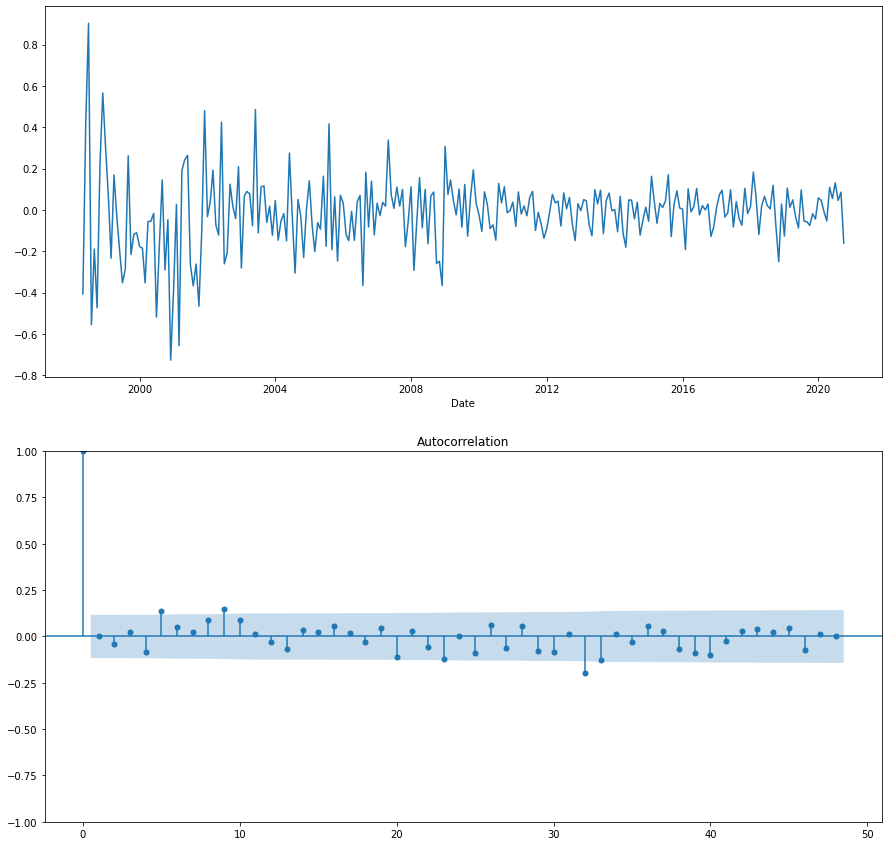

In [20]:
plt.figure(figsize=(15,15))

plt.subplot(211)
best_model.resid[12:].plot()

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[1:].values.squeeze(), lags=48, ax=ax);

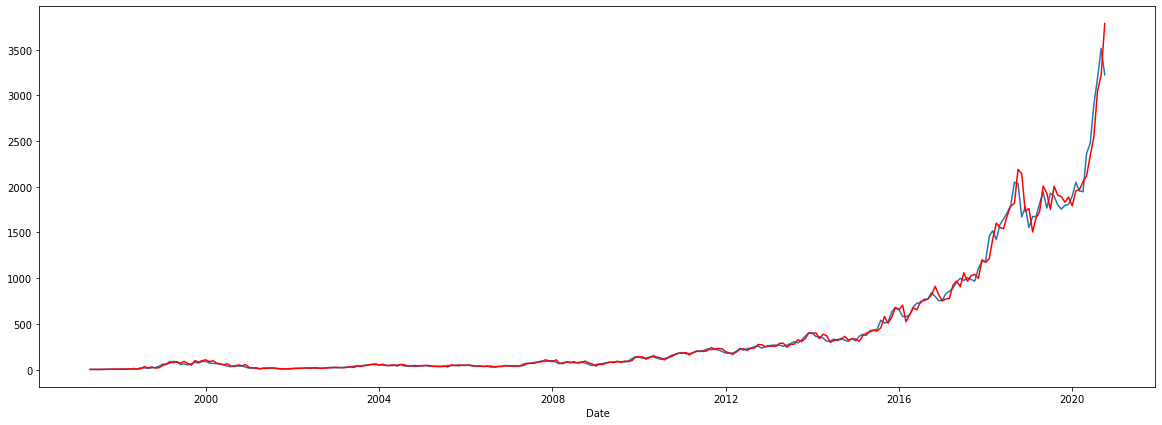

In [21]:
amazon['Model'] = np.exp(best_model.fittedvalues)

plt.figure(figsize=(20,7))

y_train.plot()
amazon['Model'].plot(c='r');

<AxesSubplot:xlabel='Date'>

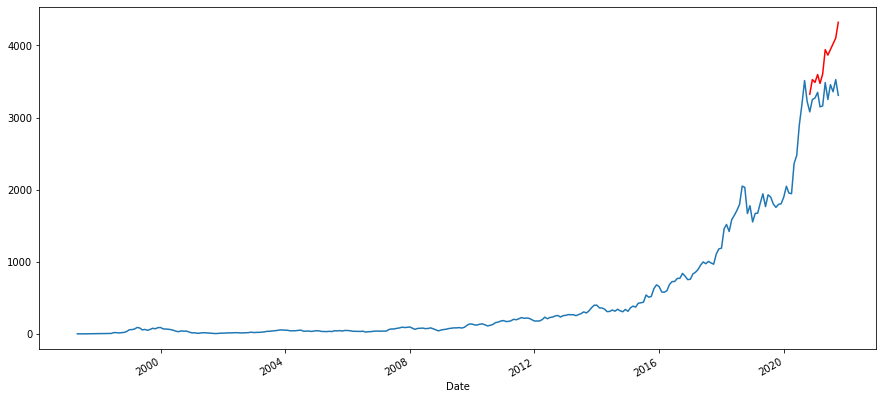

In [22]:
PREDICT_LEN = months
y_pred = np.exp(best_model.predict(start=perc, end=perc + PREDICT_LEN - 1))

plt.figure(figsize=(15,7))
amazon['High'].plot()
y_pred.plot(c='r')

In [23]:
from sklearn.metrics import mean_absolute_percentage_error

mean_absolute_percentage_error(y_test, y_pred)

0.13966430920633732